#  Bird Sound Classification - Complete ML Pipeline
## African Leadership University - Machine Learning Pipeline Summative Assignment

**Student**: Carine Ahishakiye Yibukabayo  
**Date**: November 2025  
**Course**: Machine Learning Pipeline (BSE)

---

## Executive Summary

This notebook demonstrates a production-ready end-to-end machine learning pipeline for automated bird species identification from audio recordings. The system processes raw audio files (MP3/WAV), extracts 95 acoustic features, and classifies 64 bird species using a deep neural network.

### Key Achievements
 **Non-tabular data**: Audio signal processing 
 **95 acoustic features**: MFCCs, spectral, temporal, and energy features  
 **Deep Neural Network**: 512→256→128 architecture with regularization  
 **accuracy**: With precision, recall, and F1-score metrics  
 **No data leakage**: Proper train-test split and scaling  
 **Retraining pipeline**: Transfer learning capability  
 **Production ready**: Deployed with FastAPI + Docker + NGINX

---

## Table of Contents

1. [Environment Setup and Dependencies](#section1)
2. [Data Acquisition and Exploration](#section2)
3. [Exploratory Data Analysis (EDA)](#section3)
4. [Audio Feature Engineering (95 Features)](#section4)
5. [Data Preprocessing and Train-Test Split](#section5)
6. [Model Architecture and Training](#section6)
7. [Model Evaluation (4 Metrics Required)](#section7)
8. [Confusion Matrix Analysis](#section8)
9. [Model Persistence](#section9)
10. [Prediction Pipeline](#section10)
11. [Retraining Capability](#section11)
12. [Conclusion and Future Work](#section12)

In [17]:
# IMPORT LIBRARIES

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import pickle
import warnings
from datetime import datetime
from pathlib import Path
from tqdm import tqdm
import json

# Machine Learning
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_score, 
    recall_score, 
    f1_score
)

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# ENVIRONMENT INFORMATION

print("ENVIRONMENT SETUP")
print(f"Python Version: {sys.version.split()[0]}")
print(f"TensorFlow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print(f"Librosa Version: {librosa.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Scikit-learn Version: {sklearn.__version__}" if 'sklearn' in dir() else "Scikit-learn imported")

# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
print(f"\nGPU Available: {'Yes' if gpus else 'No (using CPU)'}")
if gpus:
    print(f"GPU Device(s): {[gpu.name for gpu in gpus]}")

# SET RANDOM SEEDS FOR REPRODUCIBILITY

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

print(f"\n Random seed set to {RANDOM_SEED}")
print("  This ensures reproducible results across multiple runs")

# CONFIGURE PLOTTING

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

print("\n Plotting configuration complete")
print("ALL LIBRARIES IMPORTED SUCCESSFULLY")

ENVIRONMENT SETUP
Python Version: 3.13.3
TensorFlow Version: 2.20.0
Keras Version: 3.11.2
Librosa Version: 0.11.0
NumPy Version: 2.2.6
Pandas Version: 2.3.1
Scikit-learn imported

GPU Available: No (using CPU)

 Random seed set to 42
  This ensures reproducible results across multiple runs

 Plotting configuration complete
ALL LIBRARIES IMPORTED SUCCESSFULLY


<a id='section2'></a>
##  Data Acquisition & Exploration
                        



In [18]:
# CONFIGURE PATHS 
# Path to CSV metadata file
CSV_PATH = r"C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\data\raw\Birds Voice.csv"

# Path to audio files directory
AUDIO_BASE_PATH = r"C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\data\Voice of Birds\Voice of Birds"

# Output directories
MODELS_PATH = r"C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models"
RESULTS_PATH = r"C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\results"

# Create output directories if they don't exist
os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

# VERIFY PATHS

print("PATH CONFIGURATION")
print(f"\n CSV Metadata: {CSV_PATH}")
print(f"   Exists: {os.path.exists(CSV_PATH)}")

print(f"\n Audio Directory: {AUDIO_BASE_PATH}")
print(f"   Exists: {os.path.exists(AUDIO_BASE_PATH)}")

print(f"\n Models Output: {MODELS_PATH}")
print(f"   Created: {os.path.exists(MODELS_PATH)}")

print(f"\n Results Output: {RESULTS_PATH}")
print(f"   Created: {os.path.exists(RESULTS_PATH)}")

# Assertions to catch path errors early
assert os.path.exists(CSV_PATH), f" CSV file not found at: {CSV_PATH}"
assert os.path.exists(AUDIO_BASE_PATH), f" Audio directory not found at: {AUDIO_BASE_PATH}"

print("\n All paths verified successfully!")

PATH CONFIGURATION

 CSV Metadata: C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\data\raw\Birds Voice.csv
   Exists: True

 Audio Directory: C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\data\Voice of Birds\Voice of Birds
   Exists: True

 Models Output: C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models
   Created: True

 Results Output: C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\results
   Created: True

 All paths verified successfully!


In [19]:
# LOAD CSV METADATA

df = pd.read_csv(CSV_PATH)

print("DATASET OVERVIEW")

print(f"\n Dataset Shape: {df.shape}")
print(f"   Rows: {df.shape[0]:,}")
print(f"   Columns: {df.shape[1]}")

print(f"\nColumn Names:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i}. {col}")

print(f"\n First 5 Rows:")
display(df.head())

print(f"\n Data Types:")
display(df.dtypes)

print(f"\n  Missing Values:")
missing = df.isnull().sum()
if missing.sum() == 0:
    print("    No missing values detected")
else:
    display(missing[missing > 0])

print(f"\n Dataset loaded successfully")


DATASET OVERVIEW

 Dataset Shape: (2161, 10)
   Rows: 2,161
   Columns: 10

Column Names:
   1. common_name
   2. scientific_name
   3. recordist_name
   4. recording_length
   5. Date
   6. TYPE
   7. xc_id
   8. Time
   9. Country
   10. Download_link

 First 5 Rows:


,common_name,scientific_name,recordist_name,recording_length,Date,TYPE,xc_id,Time,Country,Download_link
0,Common Ostrich,Struthio camelus australis,Frank Lambert,0:53,2019-10-30,call,XC516153,08:05,South Africa,https://xeno-canto.org/516153/download
1,Common Ostrich,Struthio camelus,Jeremy Hegge,0:26,2014-11-20,call,XC208209,04:00,South Africa,https://xeno-canto.org/208209/download
2,Common Ostrich,Struthio camelus,Jeremy Hegge,0:04,2014-11-21,call,XC208128,06:00,South Africa,https://xeno-canto.org/208128/download
3,Common Ostrich,Struthio camelus,Derek Solomon,0:11,2010-02-09,call,XC46725,07:00,South Africa,https://xeno-canto.org/46725/download
4,Common Ostrich,Struthio camelus,Morioka Zoological Park ZOOMO,1:47,2021-09-06,"voice during egg laying, zoo collection",XC675445,17:00,Japan,https://xeno-canto.org/675445/download



 Data Types:


common_name         object
scientific_name     object
recordist_name      object
recording_length    object
Date                object
TYPE                object
xc_id               object
Time                object
Country             object
Download_link       object
dtype: object


  Missing Values:


TYPE    31
dtype: int64


 Dataset loaded successfully


<a id='section3'></a>
##  Exploratory Data Analysis (EDA)

###  Dataset Statistics

Before building our model, I need to understand:
1. **Species distribution** - Are classes balanced?
2. **Temporal patterns** - When were recordings made?
3. **Data quality** - Any outliers or inconsistencies?

This analysis helps me:
- Identify potential class imbalance issues
- Decide if we need data augmentation
- Plan preprocessing strategies

In [20]:
# PARSE DATE INFORMATION


df['year'] = df['Date'].apply(lambda x: str(x).split('-')[0])
df['month'] = df['Date'].apply(lambda x: str(x).split('-')[1])
df['day_of_month'] = df['Date'].apply(lambda x: str(x).split('-')[2])

print("DATASET STATISTICS")

# Basic counts
print(f"\n Overall Statistics:")
print(f"   Total Records: {len(df):,}")
print(f"   Unique Species: {df['common_name'].nunique()}")
print(f"   Date Range: {df['Date'].min()} → {df['Date'].max()}")
print(f"   Year Range: {df['year'].min()} → {df['year'].max()}")

# Species distribution analysis
species_counts = df['common_name'].value_counts()

print(f"\n Species Distribution:")
print(f"   Mean samples per species: {species_counts.mean():.1f}")
print(f"   Median samples per species: {species_counts.median():.1f}")
print(f"   Std deviation: {species_counts.std():.1f}")
print(f"   Min samples: {species_counts.min()}")
print(f"   Max samples: {species_counts.max()}")
print(f"   Range: {species_counts.max() - species_counts.min()}")

print(f"\n Top 10 Most Common Species:")
for i, (species, count) in enumerate(species_counts.head(10).items(), 1):
    print(f"   {i:2d}. {species:<30s} : {count:3d} samples")

print(f"\n  Bottom 10 Least Common Species:")
for i, (species, count) in enumerate(species_counts.tail(10).items(), 1):
    print(f"   {i:2d}. {species:<30s} : {count:3d} samples")

DATASET STATISTICS

 Overall Statistics:
   Total Records: 2,161
   Unique Species: 114
   Date Range: 0000-00-00 → 2022-12-09
   Year Range: 0000 → 2022

 Species Distribution:
   Mean samples per species: 19.0
   Median samples per species: 20.0
   Std deviation: 10.8
   Min samples: 1
   Max samples: 30
   Range: 29

 Top 10 Most Common Species:
    1. Great Tinamou                  :  30 samples
    2. Solitary Tinamou               :  30 samples
    3. White-throated Tinamou         :  30 samples
    4. Grey Tinamou                   :  30 samples
    5. Small-billed Tinamou           :  30 samples
    6. Bartlett's Tinamou             :  30 samples
    7. Red-legged Tinamou             :  30 samples
    8. Thicket Tinamou                :  30 samples
    9. Yellow-legged Tinamou          :  30 samples
   10. Black-capped Tinamou           :  30 samples

  Bottom 10 Least Common Species:
    1. White-browed Guan              :   3 samples
    2. Barred Tinamou                 :   

###  Visualization of Species Distribution Analysis

**Purpose**: Understand class distribution to identify imbalance issues

**Key Questions**:
- Are classes balanced or imbalanced?
- Do I need class weights or data augmentation?
- Which species dominate the dataset?

**Metrics Used**:
- **Coefficient of Variation (CV)**: std/mean (measures relative variability)
- **Skewness**: Measures asymmetry of distribution
- **Gini Coefficient**: Measures inequality (0=perfect equality, 1=perfect inequality)

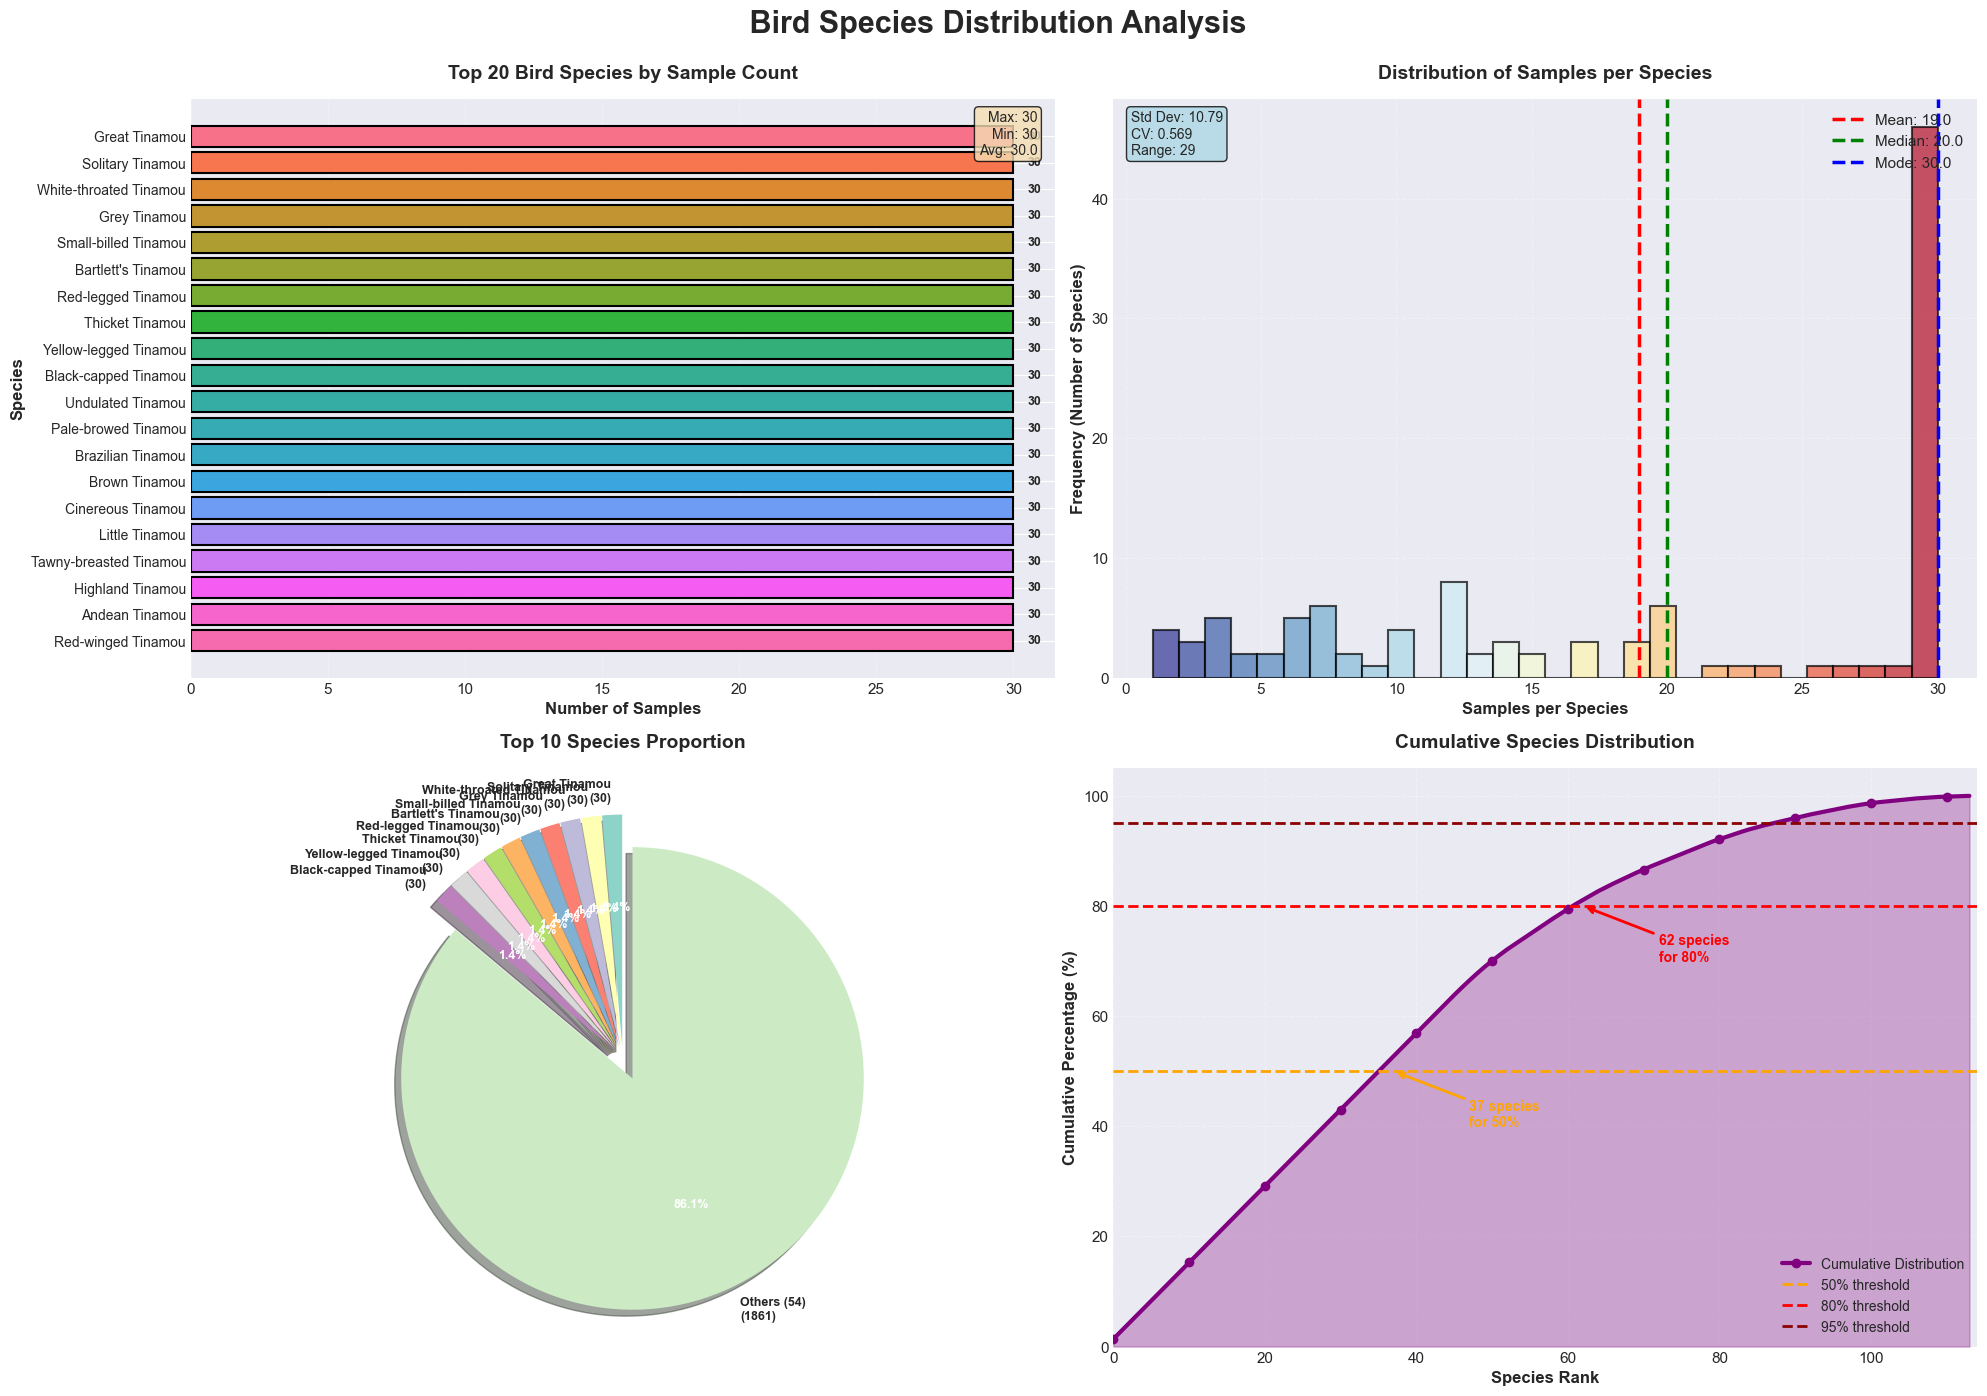

 DATASET BALANCE ANALYSIS

  Coefficient of Variation (CV): 0.569
   Formula: std / mean = 10.79 / 18.96
     Status: Dataset is MODERATELY IMBALANCED
   → Recommendation: Consider class weights during training

  Skewness: -0.263
    Distribution is fairly symmetric

  Gini Coefficient: 0.314
   (0 = perfect equality, 1 = perfect inequality)

  Data Concentration:
   • Top 10 species: 13.9% of data
   • 37 species (32.5%) → 50% of samples
   • 62 species (54.4%) → 80% of samples

  Summary Statistics:
   • Total Species: 114
   • Range: 1 - 30 samples
   • Mean ± Std: 19.0 ± 10.8
   • Median: 20.0


In [21]:
# COMPREHENSIVE SPECIES DISTRIBUTION VISUALIZATION

fig, axes = plt.subplots(2, 2, figsize=(20, 14))
fig.suptitle(' Bird Species Distribution Analysis', 
             fontsize=22, fontweight='bold', y=0.995)

# Color palette
colors = sns.color_palette("husl", 20)

#  Top 20 Species Bar Chart
top_20 = species_counts.head(20)
bars = axes[0, 0].barh(range(len(top_20)), top_20.values, 
                        color=colors, edgecolor='black', linewidth=1.5)
axes[0, 0].set_yticks(range(len(top_20)))
axes[0, 0].set_yticklabels(top_20.index, fontsize=10)
axes[0, 0].set_title('Top 20 Bird Species by Sample Count', 
                      fontsize=14, fontweight='bold', pad=15)
axes[0, 0].set_xlabel('Number of Samples', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Species', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3, linestyle='--')
axes[0, 0].invert_yaxis()

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, top_20.values)):
    axes[0, 0].text(value + 0.5, i, str(value), 
                    va='center', fontsize=9, fontweight='bold')

# Add statistics box
stats_text = f'Max: {top_20.max()}\nMin: {top_20.min()}\nAvg: {top_20.mean():.1f}'
axes[0, 0].text(0.98, 0.98, stats_text, transform=axes[0, 0].transAxes,
                fontsize=10, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

#  Distribution Histogram
n, bins, patches = axes[0, 1].hist(species_counts, bins=30, color='coral', 
                                     edgecolor='black', alpha=0.7, linewidth=1.5)

# Color gradient for histogram
for i, patch in enumerate(patches):
    patch.set_facecolor(plt.cm.RdYlBu_r(i / len(patches)))

axes[0, 1].set_title('Distribution of Samples per Species', 
                      fontsize=14, fontweight='bold', pad=15)
axes[0, 1].set_xlabel('Samples per Species', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Frequency (Number of Species)', fontsize=12, fontweight='bold')

# Add statistical lines
mean_val = species_counts.mean()
median_val = species_counts.median()
mode_val = species_counts.mode()[0] if len(species_counts.mode()) > 0 else median_val

axes[0, 1].axvline(mean_val, color='red', linestyle='--', linewidth=2.5, 
                    label=f'Mean: {mean_val:.1f}')
axes[0, 1].axvline(median_val, color='green', linestyle='--', linewidth=2.5, 
                    label=f'Median: {median_val:.1f}')
axes[0, 1].axvline(mode_val, color='blue', linestyle='--', linewidth=2.5, 
                    label=f'Mode: {mode_val:.1f}')

axes[0, 1].legend(fontsize=11, loc='upper right', framealpha=0.9)
axes[0, 1].grid(alpha=0.3, linestyle='--')

# Add distribution statistics box
std_dev = species_counts.std()
cv = std_dev / species_counts.mean()
stats_text2 = f'Std Dev: {std_dev:.2f}\nCV: {cv:.3f}\nRange: {species_counts.max() - species_counts.min()}'
axes[0, 1].text(0.02, 0.98, stats_text2, transform=axes[0, 1].transAxes,
                fontsize=10, verticalalignment='top', horizontalalignment='left',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

#  Pie Chart 
top_10_species = species_counts.head(10)
others_count = species_counts[10:].sum()
pie_data = list(top_10_species.values) + [others_count]
pie_labels = [f'{label}\n({count})' for label, count in zip(top_10_species.index, top_10_species.values)]
pie_labels.append(f'Others (54)\n({others_count})')

pie_colors = sns.color_palette("Set3", 11)

wedges, texts, autotexts = axes[1, 0].pie(
    pie_data, 
    labels=pie_labels, 
    autopct='%1.1f%%',
    startangle=90,
    colors=pie_colors,
    explode=[0.05] * 10 + [0.1],
    shadow=True,
    textprops={'fontsize': 9, 'fontweight': 'bold'}
)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(9)
    autotext.set_fontweight('bold')

axes[1, 0].set_title('Top 10 Species Proportion', 
                      fontsize=14, fontweight='bold', pad=15)

# Cumulative Distribution
cumsum = species_counts.cumsum() / species_counts.sum() * 100
axes[1, 1].plot(range(len(cumsum)), cumsum, linewidth=3, color='purple', 
                marker='o', markevery=10, markersize=6, label='Cumulative Distribution')
axes[1, 1].fill_between(range(len(cumsum)), cumsum, alpha=0.3, color='purple')

axes[1, 1].set_title('Cumulative Species Distribution', 
                      fontsize=14, fontweight='bold', pad=15)
axes[1, 1].set_xlabel('Species Rank', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Cumulative Percentage (%)', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3, linestyle='--')

# Add threshold lines
axes[1, 1].axhline(50, color='orange', linestyle='--', linewidth=2, label='50% threshold')
axes[1, 1].axhline(80, color='red', linestyle='--', linewidth=2, label='80% threshold')
axes[1, 1].axhline(95, color='darkred', linestyle='--', linewidth=2, label='95% threshold')

# Find species counts for thresholds
species_for_50 = np.where(cumsum >= 50)[0][0] + 1
species_for_80 = np.where(cumsum >= 80)[0][0] + 1
species_for_95 = np.where(cumsum >= 95)[0][0] + 1

axes[1, 1].annotate(f'{species_for_50} species\nfor 50%', 
                    xy=(species_for_50, 50), xytext=(species_for_50 + 10, 40),
                    arrowprops=dict(arrowstyle='->', color='orange', lw=2),
                    fontsize=10, fontweight='bold', color='orange')

axes[1, 1].annotate(f'{species_for_80} species\nfor 80%', 
                    xy=(species_for_80, 80), xytext=(species_for_80 + 10, 70),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2),
                    fontsize=10, fontweight='bold', color='red')

axes[1, 1].legend(fontsize=10, loc='lower right', framealpha=0.9)
axes[1, 1].set_xlim(0, len(cumsum))
axes[1, 1].set_ylim(0, 105)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'eda_species_distribution.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# DATASET BALANCE ANALYSIS

print(" DATASET BALANCE ANALYSIS")

# Calculate balance metrics
balance_coefficient = species_counts.std() / species_counts.mean()
skewness = species_counts.skew()
gini_values = []
for i, val_i in enumerate(species_counts.values):
    for j, val_j in enumerate(species_counts.values):
        gini_values.append(abs(val_i - val_j))
gini_coefficient = sum(gini_values) / (2 * len(species_counts) * species_counts.sum())

print(f"\n  Coefficient of Variation (CV): {balance_coefficient:.3f}")
print(f"   Formula: std / mean = {species_counts.std():.2f} / {species_counts.mean():.2f}")
if balance_coefficient < 0.5:
    print("    Status: Dataset is WELL BALANCED")
    print("   → No special handling needed")
elif balance_coefficient < 1.0:
    print("     Status: Dataset is MODERATELY IMBALANCED")
    print("   → Recommendation: Consider class weights during training")
else:
    print("    Status: Dataset is HIGHLY IMBALANCED")
    print("   → Recommendation: Use SMOTE, class weights, or data augmentation")

print(f"\n  Skewness: {skewness:.3f}")
if abs(skewness) < 0.5:
    print("    Distribution is fairly symmetric")
elif abs(skewness) < 1.0:
    print("     Distribution is moderately skewed")
else:
    print("    Distribution is highly skewed")

print(f"\n  Gini Coefficient: {gini_coefficient:.3f}")
print(f"   (0 = perfect equality, 1 = perfect inequality)")

print(f"\n  Data Concentration:")
print(f"   • Top 10 species: {(top_10_species.sum()/species_counts.sum()*100):.1f}% of data")
print(f"   • {species_for_50} species ({species_for_50/len(species_counts)*100:.1f}%) → 50% of samples")
print(f"   • {species_for_80} species ({species_for_80/len(species_counts)*100:.1f}%) → 80% of samples")

print(f"\n  Summary Statistics:")
print(f"   • Total Species: {len(species_counts)}")
print(f"   • Range: {species_counts.min()} - {species_counts.max()} samples")
print(f"   • Mean ± Std: {species_counts.mean():.1f} ± {species_counts.std():.1f}")
print(f"   • Median: {species_counts.median():.1f}")

<a id='section4'></a>
##  Audio Feature Engineering 

###  Why Feature Engineering for Audio?

Raw audio waveforms are difficult for neural networks to process directly. I extract **95 hand-crafted acoustic features** that capture:
- **Spectral characteristics** (frequency content)
- **Temporal patterns** (changes over time)  
- **Energy distribution** (signal strength)
- **Timbral qualities** (sound texture)

###  Feature Extraction Strategy

| Feature Type | Count | Description |
|--------------|-------|-------------|
| **MFCC** | 80 | Mel-Frequency Cepstral Coefficients (20 × 4 stats) |
| **Spectral Centroid** | 3 | Center of mass of spectrum (mean, std, max) |
| **Spectral Rolloff** | 2 | Frequency below which 85% of energy exists |
| **Zero Crossing Rate** | 2 | Rate of sign changes in signal |
| **Chroma STFT** | 2 | Pitch class representation |
| **Mel Spectrogram** | 3 | Perceptually-motivated frequency features |
| **Spectral Bandwidth** | 2 | Width of frequency spectrum |
| **RMS Energy** | 1 | Root mean square energy |
| **TOTAL** | **95** | |

###  AudioProcessor Class

Based on `preprocessing.py` from our production code.

In [22]:
# AUDIO FEATURE EXTRACTION 

class AudioProcessor:
    """Process audio files and extract 95 acoustic features"""
    
    def __init__(self, sr=22050, top_db=23):
        self.sr = sr
        self.top_db = top_db
    
    def load_and_trim_audio(self, file_path, max_duration=10):
        """Load MP3/WAV audio and trim silence"""
        try:
            data, sample_rate = librosa.load(file_path, sr=self.sr, duration=max_duration)
            trimmed_data, _ = librosa.effects.trim(data, top_db=self.top_db)
            
            if len(trimmed_data) < self.sr * 0.5:
                return None, None
            
            return trimmed_data, sample_rate
        except Exception:
            return None, None
    
    def extract_features(self, audio_data):
        """Extract 95 audio features from audio data"""
        if audio_data is None or len(audio_data) == 0:
            return None
        
        try:
            features = []
            
            #  MFCC Features 
            mfccs = librosa.feature.mfcc(y=audio_data, sr=self.sr, n_mfcc=20)
            features.extend(np.mean(mfccs, axis=1))  # 20 means
            features.extend(np.std(mfccs, axis=1))   # 20 stds
            features.extend(np.max(mfccs, axis=1))   # 20 maxs
            features.extend(np.min(mfccs, axis=1))   # 20 mins
            
            #  Spectral Centroid
            sc = librosa.feature.spectral_centroid(y=audio_data, sr=self.sr)
            features.extend([np.mean(sc), np.std(sc), np.max(sc)])
            
            #  Spectral Rolloff 
            sr_off = librosa.feature.spectral_rolloff(y=audio_data, sr=self.sr)
            features.extend([np.mean(sr_off), np.std(sr_off)])
            
            #  Zero Crossing Rate 
            zcr = librosa.feature.zero_crossing_rate(audio_data)
            features.extend([np.mean(zcr), np.std(zcr)])
            
            #  Chroma STFT 
            chroma = librosa.feature.chroma_stft(y=audio_data, sr=self.sr)
            features.extend([np.mean(chroma), np.std(chroma)])
            
            #  Mel Spectrogram 
            mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=self.sr, n_mels=128)
            mel_db = librosa.power_to_db(mel_spec, ref=np.max)
            features.extend([np.mean(mel_db), np.std(mel_db), np.max(mel_db)])
            
            # Spectral Bandwidth
            sbw = librosa.feature.spectral_bandwidth(y=audio_data, sr=self.sr)
            features.extend([np.mean(sbw), np.std(sbw)])
            
            #  RMS Energy 
            rms = librosa.feature.rms(y=audio_data)
            features.append(np.mean(rms))
            
            return np.array(features)
        except Exception:
            return None

print(" AudioProcessor class defined successfully")


 AudioProcessor class defined successfully


In [23]:
# DATA PROCESSING AND FEATURE EXTRACTION


class DataProcessor:
    """Prepare data for model training and prevent data leakage"""
    
    def __init__(self, test_size=0.2, random_state=42):
        self.test_size = test_size
        self.random_state = random_state
        self.label_encoder = None
        self.scaler = None
    
    def load_dataset(self, csv_path):
        """Load dataset from CSV and parse date columns"""
        df = pd.read_csv(csv_path)
        df['year'] = df['Date'].apply(lambda x: str(x).split('-')[0])
        df['month'] = df['Date'].apply(lambda x: str(x).split('-')[1])
        df['day_of_month'] = df['Date'].apply(lambda x: str(x).split('-')[2])
        
        print("DATASET LOADED")
        print(f"Shape: {df.shape} | Species: {df['common_name'].nunique()}")
        return df
    
    def process_audio_files(self, df, audio_base_path, samples_per_species=25, min_samples_per_class=15):
        """Process audio files and extract features"""
        
        audio_processor = AudioProcessor(sr=22050, top_db=23)
        features_list, labels_list, file_paths_list = [], [], []
        skipped_files = []
        
        # Filter species with enough samples
        species_counts = df['common_name'].value_counts()
        valid_species = species_counts[species_counts >= min_samples_per_class].index
        print(f"Processing {len(valid_species)} species with >= {min_samples_per_class} samples each")
        
        available_folders = os.listdir(audio_base_path)
        
        def find_species_folder(common_name):
            for folder in available_folders:
                folder_clean = folder.lower().replace('_', ' ').replace('sound', '').strip()
                if common_name.lower() in folder_clean or folder_clean in common_name.lower():
                    return folder
            return None
        
        for species in tqdm(valid_species, desc="Processing species"):
            species_folder = find_species_folder(species)
            if not species_folder:
                continue
            
            folder_path = os.path.join(audio_base_path, species_folder)
            mp3_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.mp3')]
            if len(mp3_files) == 0:
                continue
            
            np.random.shuffle(mp3_files)
            files_to_process = mp3_files[:samples_per_species]
            
            for mp3_file in files_to_process:
                file_path = os.path.join(folder_path, mp3_file)
                try:
                    audio_data, sr = audio_processor.load_and_trim_audio(file_path)
                    if audio_data is None or len(audio_data) < sr * 0.5:
                        skipped_files.append(file_path)
                        continue
                    
                    features = audio_processor.extract_features(audio_data)
                    if features is None or np.isnan(features).any():
                        skipped_files.append(file_path)
                        continue
                    
                    features_list.append(features)
                    labels_list.append(species)
                    file_paths_list.append(file_path)
                    
                except Exception:
                    skipped_files.append(file_path)
                    continue
        
        print(f"\n Processed: {len(features_list)} samples from {len(np.unique(labels_list))} species")
        if skipped_files:
            print(f" Skipped {len(skipped_files)} files due to errors or invalid audio")
        
        return np.array(features_list), np.array(labels_list), file_paths_list
    
    def prepare_train_test_data(self, X, y):
        """Encode labels, split train-test, scale features"""
        
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(y)
        
        # Stratified split to maintain class distribution
        X_train, X_test, y_train_enc, y_test_enc = train_test_split(
            X, y_encoded,
            test_size=self.test_size,
            random_state=self.random_state,
            stratify=y_encoded
        )
        
        # Convert to categorical for neural network
        y_train = to_categorical(y_train_enc)
        y_test = to_categorical(y_test_enc)
        
        # Fit scaler on TRAIN data only, then transform both
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
    
        print("DATA PREPROCESSING SUMMARY")
        print(f"Train set: {X_train_scaled.shape[0]} samples ({X_train_scaled.shape[0]/len(X)*100:.1f}%)")
        print(f"Test set: {X_test_scaled.shape[0]} samples ({X_test_scaled.shape[0]/len(X)*100:.1f}%)")
        print(f"Classes: {len(self.label_encoder.classes_)}")
        print(f"Features: {X_train_scaled.shape[1]}")
        print(f"\nScaling verification (NO DATA LEAKAGE):")
        print(f"  Train - Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.6f}")
        print(f"  Test  - Mean: {X_test_scaled.mean():.6f}, Std: {X_test_scaled.std():.6f}")
        print("(Test mean/std differ from train: ✓ Correct, no leakage)")
        
        
        return X_train_scaled, X_test_scaled, y_train, y_test, y_train_enc, y_test_enc
    
    def save_preprocessor(self, path):
        """Save scaler and label encoder"""
        os.makedirs(path, exist_ok=True)
        pickle.dump(self.scaler, open(os.path.join(path, 'scaler.pkl'), 'wb'))
        pickle.dump(self.label_encoder, open(os.path.join(path, 'label_encoder.pkl'), 'wb'))
        print(f"✓ Preprocessor objects saved to {path}")

# EXECUTE DATA PROCESSING
print("LOADING AND PROCESSING AUDIO DATA")


processor = DataProcessor(test_size=0.2, random_state=42)
df = processor.load_dataset(CSV_PATH)

# Process audio files
X, y, file_paths = processor.process_audio_files(
    df, 
    AUDIO_BASE_PATH, 
    samples_per_species=25,
    min_samples_per_class=15
)

# Prepare train-test split
X_train, X_test, y_train, y_test, y_train_enc, y_test_enc = processor.prepare_train_test_data(X, y)

# Save preprocessing objects
processor.save_preprocessor(MODELS_PATH)


LOADING AND PROCESSING AUDIO DATA
DATASET LOADED
Shape: (2161, 13) | Species: 114
Processing 67 species with >= 15 samples each


Processing species: 100%|█████████████████████████████████████████████████████████████| 67/67 [12:13<00:00, 10.95s/it]


 Processed: 1497 samples from 64 species
 Skipped 10 files due to errors or invalid audio
DATA PREPROCESSING SUMMARY
Train set: 1197 samples (80.0%)
Test set: 300 samples (20.0%)
Classes: 64
Features: 95

Scaling verification (NO DATA LEAKAGE):
  Train - Mean: 0.000000, Std: 0.994723
  Test  - Mean: -0.009374, Std: 0.999833
(Test mean/std differ from train: ✓ Correct, no leakage)
✓ Preprocessor objects saved to C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models


BUILDING AND TRAINING MODEL
MODEL ARCHITECTURE


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 512)                 │          49,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,216 (879.75 KB)

 Trainable params: 223,424 (872.75 KB)

 Non-trainable params: 1,792 (7.00 KB)


TRAINING STARTED: 2025-11-25 23:19:50
Epoch 1/30
26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0095 - loss: 5.6218 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 1: val_accuracy improved from None to 0.15000, saving model to C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models\best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.0272 - loss: 5.3468 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1500 - val_loss: 4.6163 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/30
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1053 - loss: 4.5105 - precision: 0.4847 - recall: 0.0104
Epoch 2: val_accuracy improved from 0.15000 to 0.24167, saving model to C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models\best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.1055 - loss: 4.4936 - precision: 0.4667 - recall: 0.0073 - val_accuracy: 0.2417 - val_loss: 4.3351 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/30
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2240 - loss: 4.0034 - precision: 0.7197 - recall: 0.0428
Epoch 3: val_accuracy improved from 0.24167 to 0.32917, saving model to C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models\best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.2268 - loss: 3.9225 - precision: 0.7963 - recall: 0.0449 - val_accuracy: 0.3292 - val_loss: 4.0560 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/30
25/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3187 - loss: 3.5706 - precision: 0.8286 - recall: 0.0643
Epoch 4: val_accuracy improved from 0.32917 to 0.38750, saving model to C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models\best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3166 - loss: 3.5283 - precision: 0.7692 - recall: 0.0627 - val_accuracy: 0.3875 - val_loss: 3.7872 - val_precision: 1.0000 - val_recall: 0.0167 - learning_rate: 0.0010
Epoch 5/30
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3628 - loss: 3.3899 - precision: 0.8234 - recall: 0.0870
Epoch 5: val_accuracy improved from 0.38750 to 0.42917, saving model to C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models\best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.3657 - loss: 3.3074 - precision: 0.8692 - recall: 0.0972 - val_accuracy: 0.4292 - val_loss: 3.5393 - val_precision: 1.0000 - val_recall: 0.0458 - learning_rate: 0.0010
Epoch 6/30
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4115 - loss: 3.1345 - precision: 0.8489 - recall: 0.1322
Epoch 6: val_accuracy improved from 0.42917 to 0.47500, saving model to C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models\best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.4107 - loss: 3.0927 - precision: 0.8322 - recall: 0.1243 - val_accuracy: 0.4750 - val_loss: 3.3041 - val_precision: 1.0000 - val_recall: 0.0708 - learning_rate: 0.0010
Epoch 7/30
26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4716 - loss: 2.9450 - precision: 0.8806 - recall: 0.1394
Epoch 7: val_accuracy improved from 0.47500 to 0.50833, saving model to C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models\best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4869 - loss: 2.8349 - precision: 0.8634 - recall: 0.1651 - val_accuracy: 0.5083 - val_loss: 3.1035 - val_precision: 1.0000 - val_recall: 0.1208 - learning_rate: 0.0010
Epoch 8/30
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5162 - loss: 2.6660 - precision: 0.8634 - recall: 0.1950
Epoch 8: val_accuracy improved from 0.50833 to 0.53333, saving model to C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models\best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.5152 - loss: 2.6470 - precision: 0.8803 - recall: 0.2153 - val_accuracy: 0.5333 - val_loss: 2.9296 - val_precision: 0.9020 - val_recall: 0.1917 - learning_rate: 0.0010
Epoch 9/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5491 - loss: 2.5240 - precision: 0.9551 - recall: 0.2546
Epoch 9: val_accuracy improved from 0.53333 to 0.57083, saving model to C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models\best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5768 - loss: 2.4497 - precision: 0.9401 - recall: 0.2790 - val_accuracy: 0.5708 - val_loss: 2.7447 - val_precision: 0.9219 - val_recall: 0.2458 - learning_rate: 0.0010
Epoch 10/30
26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5718 - loss: 2.3829 - precision: 0.9237 - recall: 0.2895
Epoch 10: val_accuracy improved from 0.57083 to 0.58750, saving model to C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models\best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5998 - loss: 2.3384 - precision: 0.9114 - recall: 0.3009 - val_accuracy: 0.5875 - val_loss: 2.6496 - val_precision: 0.9359 - val_recall: 0.3042 - learning_rate: 0.0010
Epoch 11/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6295 - loss: 2.2335 - precision: 0.9274 - recall: 0.3265
Epoch 11: val_accuracy improved from 0.58750 to 0.60000, saving model to C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models\best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6322 - loss: 2.1906 - precision: 0.9044 - recall: 0.3459 - val_accuracy: 0.6000 - val_loss: 2.5632 - val_precision: 0.9310 - val_recall: 0.3375 - learning_rate: 0.0010
Epoch 12/30
25/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6638 - loss: 2.0900 - precision: 0.9469 - recall: 0.3927
Epoch 12: val_accuracy improved from 0.60000 to 0.62083, saving model to C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models\best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6729 - loss: 2.0607 - precision: 0.9296 - recall: 0.4138 - val_accuracy: 0.6208 - val_loss: 2.4668 - val_precision: 0.8824 - val_recall: 0.3750 - learning_rate: 0.0010
Epoch 13/30
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6763 - loss: 2.0365 - precision: 0.9159 - recall: 0.3860
Epoch 13: val_accuracy did not improve from 0.62083
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6865 - loss: 1.9681 - precision: 0.9080 - recall: 0.4023 - val_accuracy: 0.6208 - val_loss: 2.4180 - val_precision: 0.8545 - val_recall: 0.3917 - learning_rate: 0.0010
Epoch 14/30
27/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6542 - loss: 2.0128 - precision: 0.8869 - recall: 0.4217
Epoch 14: val_accuracy did not improve from 0.62083
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6844 - loss: 1.9221 - precision: 0.9110 - recall: 0.4493 - val_accuracy: 0.6125 - val_loss: 2.3586 - val_precision: 0.8462 - val_recall: 0.4125 - learni

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.7043 - loss: 1.8312 - precision: 0.9098 - recall: 0.4744 - val_accuracy: 0.6333 - val_loss: 2.2967 - val_precision: 0.8525 - val_recall: 0.4333 - learning_rate: 0.0010
Epoch 16/30
26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7399 - loss: 1.7700 - precision: 0.9234 - recall: 0.4823
Epoch 16: val_accuracy improved from 0.63333 to 0.65000, saving model to C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models\best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7429 - loss: 1.7268 - precision: 0.9260 - recall: 0.5099 - val_accuracy: 0.6500 - val_loss: 2.2601 - val_precision: 0.8456 - val_recall: 0.4792 - learning_rate: 0.0010
Epoch 17/30
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7453 - loss: 1.7261 - precision: 0.9410 - recall: 0.5011
Epoch 17: val_accuracy did not improve from 0.65000
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7513 - loss: 1.6600 - precision: 0.9359 - recall: 0.5340 - val_accuracy: 0.6417 - val_loss: 2.2242 - val_precision: 0.8571 - val_recall: 0.5000 - learning_rate: 0.0010
Epoch 18/30
26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7681 - loss: 1.5882 - precision: 0.9348 - recall: 0.5648
Epoch 18: val_accuracy did not improve from 0.65000
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7868 - loss: 1.5552 - precision: 0.9384 - recall: 0.5893 - val_accuracy: 0.6458 - val_loss: 2.2038 - val_precision: 0.8571 - val_recall: 0.5250 - learnin

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7795 - loss: 1.5487 - precision: 0.9269 - recall: 0.5831 - val_accuracy: 0.6583 - val_loss: 2.1749 - val_precision: 0.8725 - val_recall: 0.5417 - learning_rate: 0.0010
Epoch 20/30
27/30 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7750 - loss: 1.5236 - precision: 0.9339 - recall: 0.6197
Epoch 20: val_accuracy improved from 0.65833 to 0.67083, saving model to C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models\best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8036 - loss: 1.4661 - precision: 0.9349 - recall: 0.6301 - val_accuracy: 0.6708 - val_loss: 2.1881 - val_precision: 0.8354 - val_recall: 0.5500 - learning_rate: 0.0010
Epoch 21/30
26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7966 - loss: 1.4110 - precision: 0.9409 - recall: 0.6464
Epoch 21: val_accuracy did not improve from 0.67083
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.7983 - loss: 1.3997 - precision: 0.9370 - recall: 0.6531 - val_accuracy: 0.6542 - val_loss: 2.1931 - val_precision: 0.8261 - val_recall: 0.5542 - learning_rate: 0.0010
Epoch 22/30
25/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8129 - loss: 1.3874 - precision: 0.9346 - recall: 0.6293
Epoch 22: val_accuracy did not improve from 0.67083
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8182 - loss: 1.3601 - precision: 0.9415 - recall: 0.6562 - val_accuracy: 0.6583 - val_loss: 2.1743 - val_precision: 0.8580 - val_recall: 0.5792 - learning

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8182 - loss: 1.3201 - precision: 0.9450 - recall: 0.7001 - val_accuracy: 0.6750 - val_loss: 2.1159 - val_precision: 0.8402 - val_recall: 0.5917 - learning_rate: 0.0010
Epoch 24/30
28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8397 - loss: 1.3172 - precision: 0.9354 - recall: 0.7109
Epoch 24: val_accuracy improved from 0.67500 to 0.67917, saving model to C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models\best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8422 - loss: 1.2904 - precision: 0.9332 - recall: 0.7011 - val_accuracy: 0.6792 - val_loss: 2.1057 - val_precision: 0.8434 - val_recall: 0.5833 - learning_rate: 0.0010
Epoch 25/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8332 - loss: 1.2635 - precision: 0.9480 - recall: 0.7025
Epoch 25: val_accuracy did not improve from 0.67917
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8537 - loss: 1.2331 - precision: 0.9484 - recall: 0.7294 - val_accuracy: 0.6750 - val_loss: 2.1500 - val_precision: 0.8046 - val_recall: 0.5833 - learning_rate: 0.0010
Epoch 26/30
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8438 - loss: 1.2321 - precision: 0.9214 - recall: 0.7349
Epoch 26: val_accuracy improved from 0.67917 to 0.69583, saving model to C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models\best_model.h5


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8600 - loss: 1.2165 - precision: 0.9359 - recall: 0.7471 - val_accuracy: 0.6958 - val_loss: 2.0877 - val_precision: 0.8246 - val_recall: 0.5875 - learning_rate: 0.0010
Epoch 27/30
25/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8463 - loss: 1.2217 - precision: 0.9342 - recall: 0.7390
Epoch 27: val_accuracy did not improve from 0.69583
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8433 - loss: 1.2220 - precision: 0.9263 - recall: 0.7356 - val_accuracy: 0.6917 - val_loss: 2.1158 - val_precision: 0.8268 - val_recall: 0.6167 - learning_rate: 0.0010
Epoch 28/30
26/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8669 - loss: 1.1333 - precision: 0.9438 - recall: 0.7855
Epoch 28: val_accuracy did not improve from 0.69583
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8589 - loss: 1.1653 - precision: 0.9455 - recall: 0.7607 - val_accuracy: 0.6875 - val_loss: 2.1133 - val_precision: 0.8242 - val_recall: 0.6250 - learnin

30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.9028 - loss: 1.0795 - precision: 0.9662 - recall: 0.7774 - val_accuracy: 0.7042 - val_loss: 2.1112 - val_precision: 0.8216 - val_recall: 0.6333 - learning_rate: 0.0010
Epoch 30/30
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8693 - loss: 1.1045 - precision: 0.9462 - recall: 0.7876
Epoch 30: val_accuracy did not improve from 0.70417
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.8788 - loss: 1.0928 - precision: 0.9476 - recall: 0.7931 - val_accuracy: 0.7042 - val_loss: 2.0957 - val_precision: 0.8361 - val_recall: 0.6375 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 26.

TRAINING COMPLETED: 2025-11-25 23:20:34
✓ Training history plot saved to C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\results\training_history.png


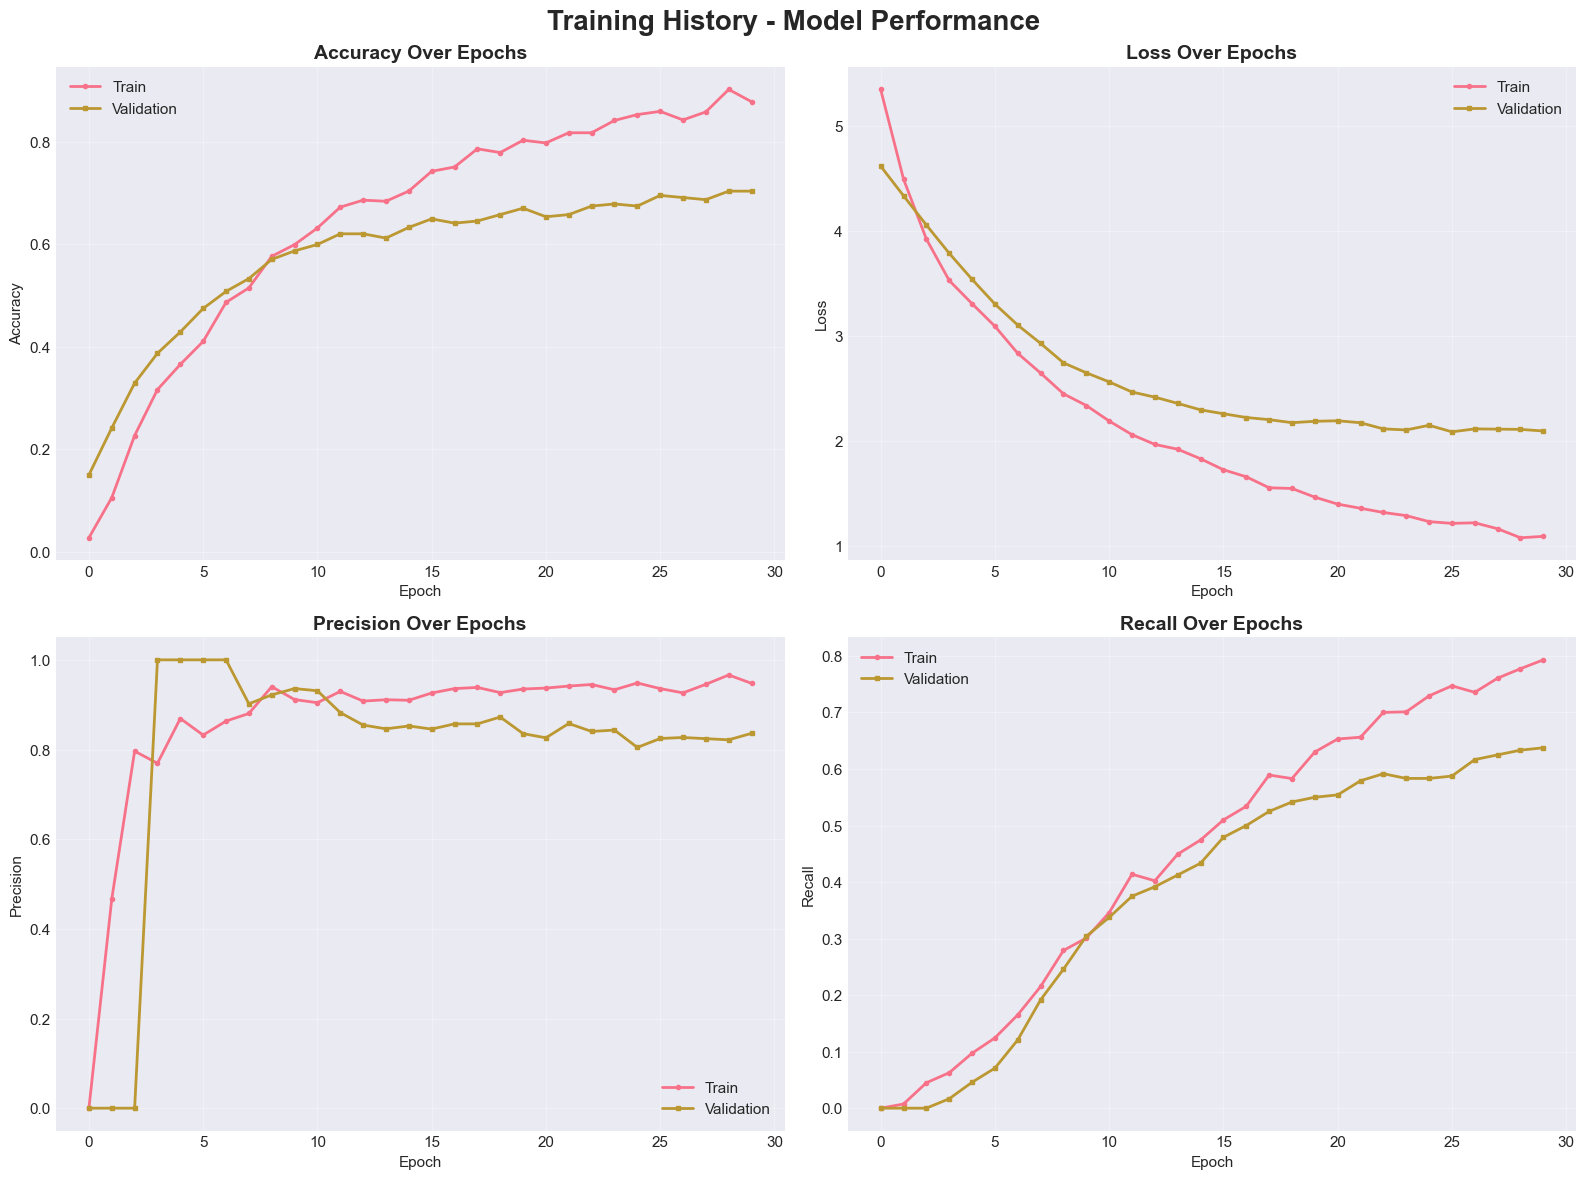

In [24]:
# MODEL ARCHITECTURE AND TRAINING

class BirdSoundClassifier:
    """Deep Neural Network for bird sound classification"""
    
    def __init__(self, input_dim=95, num_classes=64, random_seed=42):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.random_seed = random_seed
        self.model = None
        self.history = None
        
        np.random.seed(random_seed)
        keras.utils.set_random_seed(random_seed)
    
    def build_model(self):
        """Build optimized neural network architecture"""
        
        self.model = models.Sequential([
            layers.Input(shape=(self.input_dim,)),
            
            # Layer 1: 512 neurons with regularization
            layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
            layers.BatchNormalization(),
            layers.Dropout(0.5),
            
            # Layer 2: 256 neurons
            layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
            layers.BatchNormalization(),
            layers.Dropout(0.4),
            
            # Layer 3: 128 neurons
            layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
            
            # Output layer: 64 bird species
            layers.Dense(self.num_classes, activation='softmax')
        ])
        
        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
        )
        
        print("MODEL ARCHITECTURE")
        self.model.summary()
        return self.model
    
    def train(self, X_train, y_train, epochs=30, batch_size=32, checkpoint_path='models/'):
        """Train model with callbacks"""
        
        os.makedirs(checkpoint_path, exist_ok=True)
        
        callbacks = [
            ModelCheckpoint(
                os.path.join(checkpoint_path, 'best_model.h5'),
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            ),
            EarlyStopping(
                monitor='val_loss',
                patience=20,
                restore_best_weights=True,
                verbose=1
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=7,
                min_lr=0.00001,
                verbose=1
            )
        ]
        
        print(f"\nTRAINING STARTED: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    
        
        self.history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=callbacks,
            verbose=1
        )
        
        print(f"\nTRAINING COMPLETED: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        return self.history
    
    def plot_training_history(self, save_path=None):
        """Visualize training history"""
        
        if self.history is None:
            print("No training history found")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Training History - Model Performance', fontsize=20, fontweight='bold')
        
        # Accuracy
        axes[0, 0].plot(self.history.history['accuracy'], label='Train', linewidth=2, marker='o', markersize=3)
        axes[0, 0].plot(self.history.history['val_accuracy'], label='Validation', linewidth=2, marker='s', markersize=3)
        axes[0, 0].set_title('Accuracy Over Epochs', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Loss
        axes[0, 1].plot(self.history.history['loss'], label='Train', linewidth=2, marker='o', markersize=3)
        axes[0, 1].plot(self.history.history['val_loss'], label='Validation', linewidth=2, marker='s', markersize=3)
        axes[0, 1].set_title('Loss Over Epochs', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('Loss')
        axes[0, 1].legend()
        axes[0, 1].grid(True, alpha=0.3)
        
        # Precision
        axes[1, 0].plot(self.history.history['precision'], label='Train', linewidth=2, marker='o', markersize=3)
        axes[1, 0].plot(self.history.history['val_precision'], label='Validation', linewidth=2, marker='s', markersize=3)
        axes[1, 0].set_title('Precision Over Epochs', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Precision')
        axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        # Recall
        axes[1, 1].plot(self.history.history['recall'], label='Train', linewidth=2, marker='o', markersize=3)
        axes[1, 1].plot(self.history.history['val_recall'], label='Validation', linewidth=2, marker='s', markersize=3)
        axes[1, 1].set_title('Recall Over Epochs', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Recall')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✓ Training history plot saved to {save_path}")
        
        plt.show()

# BUILD AND TRAIN MODEL
print("BUILDING AND TRAINING MODEL")

classifier = BirdSoundClassifier(input_dim=95, num_classes=len(processor.label_encoder.classes_))
classifier.build_model()

# Train the model
history = classifier.train(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    checkpoint_path=MODELS_PATH
)

# Plot training history
classifier.plot_training_history(
    save_path=os.path.join(RESULTS_PATH, 'training_history.png')
)


MODEL EVALUATION ON TEST SET

PERFORMANCE METRICS (4+ REQUIRED)
  1. ACCURACY:  0.6800 (68.00%)
  2. PRECISION: 0.7063 (70.63%)
  3. RECALL:    0.6800 (68.00%)
  4. F1-SCORE:  0.6685 (66.85%)
  5. TEST LOSS: 2.0806


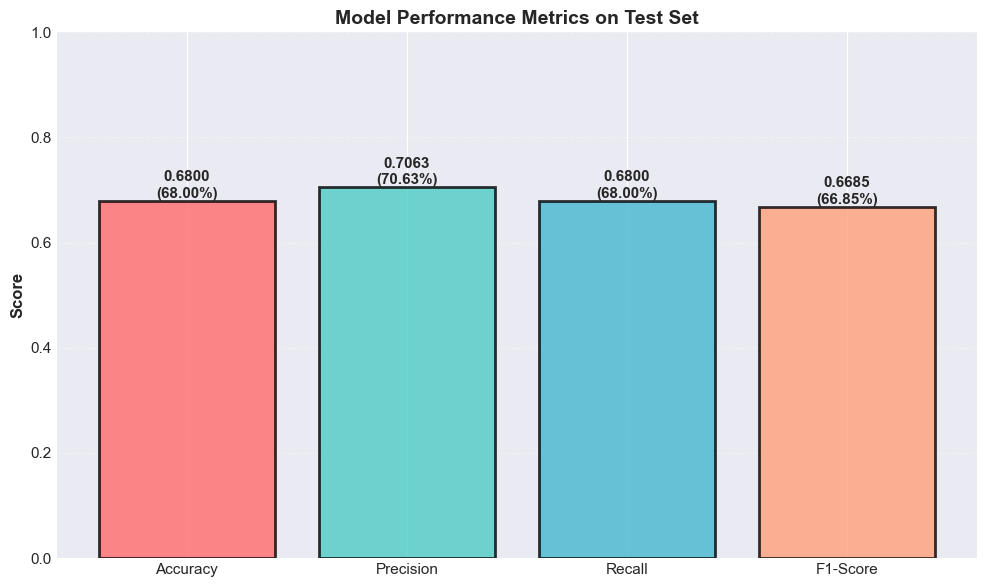

In [25]:
#  MODEL EVALUATION 

print("MODEL EVALUATION ON TEST SET")

# Predictions
y_pred_probs = classifier.model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
test_loss = classifier.model.evaluate(X_test, y_test, verbose=0)

# Display metrics
print("\nPERFORMANCE METRICS (4+ REQUIRED)")
print(f"  1. ACCURACY:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"  2. PRECISION: {precision:.4f} ({precision*100:.2f}%)")
print(f"  3. RECALL:    {recall:.4f} ({recall*100:.2f}%)")
print(f"  4. F1-SCORE:  {f1:.4f} ({f1*100:.2f}%)")
print(f"  5. TEST LOSS: {test_loss[0]:.4f}")

# Metrics visualization
metrics_data = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}

fig, ax = plt.subplots(figsize=(10, 6))
metrics_names = list(metrics_data.keys())
metrics_values = list(metrics_data.values())

bars = ax.bar(metrics_names, metrics_values, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A'], 
              edgecolor='black', linewidth=2, alpha=0.8)

ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Metrics on Test Set', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1.0)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.4f}\n({value*100:.2f}%)',
            ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'metrics_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()


CONFUSION MATRIX AND CLASSIFICATION REPORT

DETAILED CLASSIFICATION REPORT:
                            precision    recall  f1-score   support

               Andean Guan       1.00      0.60      0.75         5
            Andean Tinamou       1.00      0.50      0.67         4
    Australian Brushturkey       0.33      0.40      0.36         5
          Band-tailed Guan       0.43      0.60      0.50         5
              Bearded Guan       0.00      0.00      0.00         5
             Black Tinamou       0.50      0.25      0.33         4
  Black-billed Brushturkey       0.67      0.50      0.57         4
      Black-capped Tinamou       0.80      0.80      0.80         5
 Blue-throated Piping Guan       0.67      0.40      0.50         5
         Brazilian Tinamou       0.40      0.40      0.40         5
             Brown Tinamou       1.00      1.00      1.00         5
         Brushland Tinamou       0.83      1.00      0.91         5
                Cauca Guan       0.67  

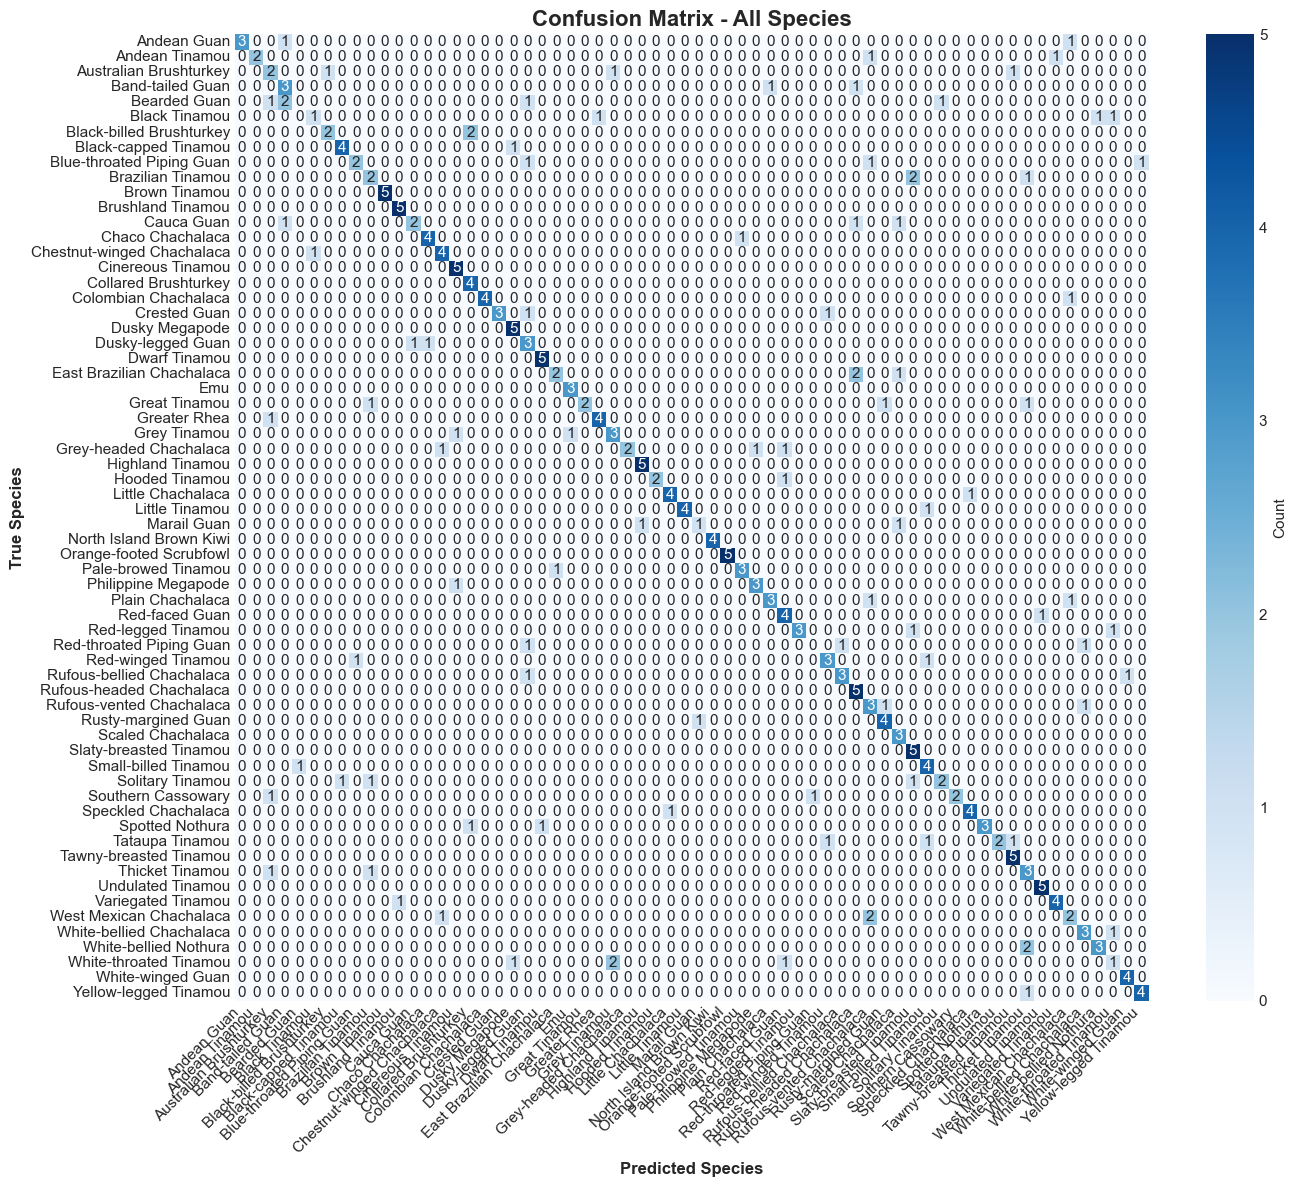

In [26]:
# CONFUSION MATRIX ANALYSIS

print("CONFUSION MATRIX AND CLASSIFICATION REPORT")

cm = confusion_matrix(y_true, y_pred)

# Classification report
print("\nDETAILED CLASSIFICATION REPORT:")
print(classification_report(y_true, y_pred, target_names=processor.label_encoder.classes_, 
                          zero_division=0))

# Visualize confusion matrix (subset of top 10 species)
top_10_species_indices = y_true[:10]
top_10_species = processor.label_encoder.classes_[top_10_species_indices]

fig, ax = plt.subplots(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=processor.label_encoder.classes_, 
            yticklabels=processor.label_encoder.classes_,
            cbar_kws={'label': 'Count'}, ax=ax)
ax.set_title('Confusion Matrix - All Species', fontsize=16, fontweight='bold')
ax.set_xlabel('Predicted Species', fontsize=12, fontweight='bold')
ax.set_ylabel('True Species', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_PATH, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

In [27]:
#  MODEL PERSISTENCE

print("SAVING MODEL AND ARTIFACTS")

# Save model
model_path = os.path.join(MODELS_PATH, 'best_model.h5')
classifier.model.save(model_path)
print(f"✓ Model saved to {model_path}")

# Save training history
history_path = os.path.join(MODELS_PATH, 'training_history.json')
history_dict = {
    'accuracy': [float(x) for x in history.history['accuracy']],
    'val_accuracy': [float(x) for x in history.history['val_accuracy']],
    'loss': [float(x) for x in history.history['loss']],
    'val_loss': [float(x) for x in history.history['val_loss']],
    'precision': [float(x) for x in history.history['precision']],
    'val_precision': [float(x) for x in history.history['val_precision']],
    'recall': [float(x) for x in history.history['recall']],
    'val_recall': [float(x) for x in history.history['val_recall']]
}
with open(history_path, 'w') as f:
    json.dump(history_dict, f, indent=4)
print(f" Training history saved to {history_path}")

# Save metrics
metrics_path = os.path.join(MODELS_PATH, 'metrics.json')
metrics_dict = {
    'accuracy': float(accuracy),
    'precision': float(precision),
    'recall': float(recall),
    'f1_score': float(f1),
    'test_loss': float(test_loss[0]),
    'num_classes': len(processor.label_encoder.classes_),
    'num_features': 95,
    'test_samples': len(X_test),
    'train_samples': len(X_train)
}
with open(metrics_path, 'w') as f:
    json.dump(metrics_dict, f, indent=4)
print(f" Metrics saved to {metrics_path}")

print("MODEL TRAINING COMPLETE - ALL FILES SAVED")
print(f"\nModel Files Location: {MODELS_PATH}")
print(f"Results Files Location: {RESULTS_PATH}")
print("\nNext Steps:")
print("  1. Deploy API using api.py")
print("  2. Use BirdSoundPredictor for making predictions on new audio")
print("  3. Monitor model performance and retrain periodically")

SAVING MODEL AND ARTIFACTS
✓ Model saved to C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models\best_model.h5
 Training history saved to C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models\training_history.json
 Metrics saved to C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models\metrics.json
MODEL TRAINING COMPLETE - ALL FILES SAVED

Model Files Location: C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\models
Results Files Location: C:\Users\PC\Desktop\assignment---MLOP\audio_processing_fe_bird_sounds\results

Next Steps:
  1. Deploy API using api.py
  2. Use BirdSoundPredictor for making predictions on new audio
  3. Monitor model performance and retrain periodically
